## Calculateクラス
### LoadData(): データを読みこむメソッド
- @param pop: 人口メッシュデータ（中心緯度経度、人口データを持つgeojson形式のデータ）
- @param com: 商業集積地区データ（中心緯度経度、売り場面積、売上高を持つgeojson形式のデータ）
            
### Dist(): ヒュべニの公式を用いた二点の距離を求めるメソッド
- @param p1: 緯度経度をリストで持つ地点
- @param p2: 緯度経度をリストで持つ地点

### oneAttract(): 顧客が店舗に行く確率を求めるメソッド
- @apram distList: すべての店舗までの距離のリスト
- @param areaList: すべての店舗の売場面積のリスト
- @param area: 面積補正係数
- @param dist: 距離補正係数
- @return 店舗の魅力度のリスト

### CleanList(): リストの-9999を0に変換するメソッド
- @param ln: 変換するリスト
- @return 変換後のリスト

### PredictSale(): 売上高を求めるメソッド
- @param pop_ptList 人口メッシュの緯度経度リスト
- @param pop_popList 人口メッシュの人口リスト
- @param com_ptList 商業施設の緯度経度リスト
- @param com_areaList 商業施設の売り場面積リスト
- @param area,dist 面積補正係数,距離補正係数
- @return predictSale 売上の予測値

## ライブラリ

In [1]:
import numpy as np
import json
import tqdm
from huffcalculate import Calculate
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


## Calculateクラスのコンストラクタ

In [2]:
calculate = Calculate('100_pop.geojson', 'A_com.geojson')
(pop, com) = calculate.LoadData()

## GeoJSON形式を読み込む

In [3]:
#100mメッシュの点を取得
pop_ptList = [i['geometry']['coordinates'] for i in pop['features']]
#商業施設座標の取得
com_ptList = [i['geometry']['coordinates'] for i in com['features']]

# 商業集積地区の名称を取得
com_name = [i['properties']['field_7'] for i in com['features']]

#売場面積の取得
com_areaList = [i['properties']['売場面積'] for i in com['features']]
# com_areaList = [n.replace('X', '0') for n in com_areaList]
# com_areaList = np.array([float(n.replace(',', '')) for n in com_areaList])
#100mメッシュの人口を取得, -9999を0に変換
pop_popList = [i['properties']['H27総人口'] for i in pop['features']]
pop_popList = calculate.CleanList(pop_popList)

#売り上げを取得
com_saleList = [i['properties']['年間商品販売額'] for i in com['features']]
#秘匿をゼロに
# com_saleList = [n.replace('X', '0') for n in com_saleList]
# com_saleList = np.array([float(n.replace(',', '')) for n in com_saleList])

#出力用に取得
#meshcodeの取得
pop_meshcodeList = [i['properties']['MESHCODE'] for i in pop['features']]
#keycodeの取得
pop_keycodeList = [i['properties']['KEYCODE'] for i in pop['features']]

#idを作成
id = np.arange(len(com_areaList))

# 基本プロット

(array([206.,   9.,   5.,   3.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([5.800000e+01, 1.450420e+04, 2.895040e+04, 4.339660e+04,
        5.784280e+04, 7.228900e+04, 8.673520e+04, 1.011814e+05,
        1.156276e+05, 1.300738e+05, 1.445200e+05]),
 <a list of 10 Patch objects>)

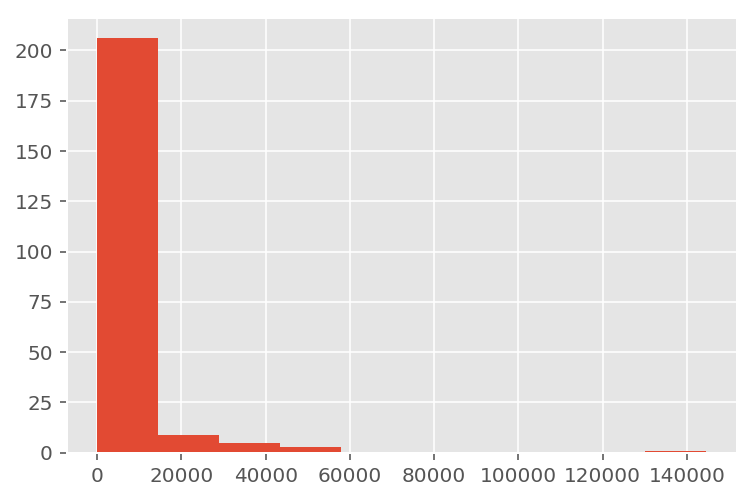

In [4]:
# 売場面積のプロット
plt.hist(com_areaList)

(array([217.,   4.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([1.60000e+01, 2.70330e+04, 5.40500e+04, 8.10670e+04, 1.08084e+05,
        1.35101e+05, 1.62118e+05, 1.89135e+05, 2.16152e+05, 2.43169e+05,
        2.70186e+05]),
 <a list of 10 Patch objects>)

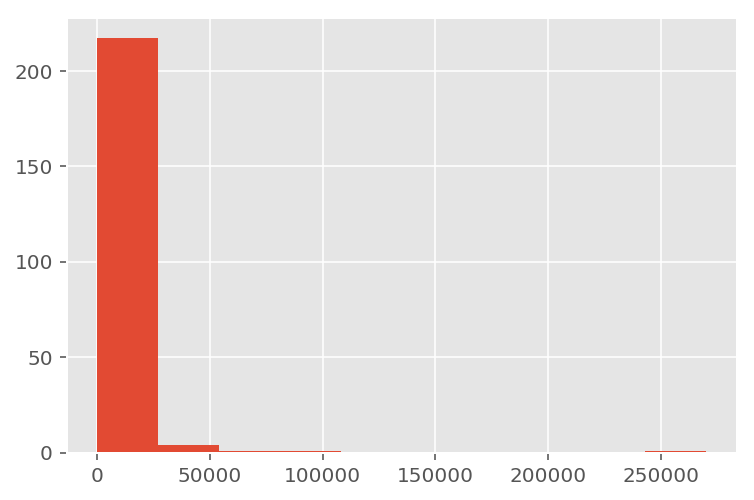

In [5]:
# 元の売り上げのプロット
plt.hist(com_saleList)

## 比例定数の算出
- 売上高/人口 = k(円/人)

In [6]:
popSum = np.sum(pop_popList)
saleSum = np.sum(com_saleList)
k = saleSum / popSum
k

0.5157552019268294

## 係数の定義
- @param area: 面積のべき数
- @param dist: 距離のべき数

In [7]:
area = 1.05
dist = 0.62

## 売上高の予測

In [8]:
predictList = calculate.PredictSale(pop_ptList, pop_popList, com_ptList, com_areaList, area, dist, 400)

100%|██████████| 32564/32564 [01:19<00:00, 408.13it/s]


## 残差の計算

In [9]:
e = com_saleList - k*predictList

## 平均二乗誤差

In [10]:
RMSE = np.sqrt(np.sum(e**2)/len(com_saleList))
RMSE

7929.839005631826

In [12]:
RMSE/com_saleList

array([8.06697763e+00, 1.36721362e+02, 2.62577451e+01, 1.49281608e+00,
       5.44257996e+00, 8.91995389e+00, 1.68361762e+01, 6.01200834e+00,
       5.35799933e+01, 2.05011350e+00, 1.44178891e+02, 3.00600417e+00,
       2.51748913e-01, 8.26024896e+00, 1.23903734e+02, 8.19198244e+00,
       6.55954918e-01, 7.92508396e-01, 2.05436244e+01, 1.37432218e+01,
       3.79418134e+01, 4.33324536e+00, 9.49681318e+00, 1.99242186e+01,
       2.68808102e+01, 1.85710515e+01, 4.05618363e+00, 3.25794536e-01,
       2.87834447e+00, 3.09276092e+00, 3.26868879e+00, 1.32163983e+02,
       2.33230559e+01, 9.61192607e+00, 1.44705091e+01, 1.23903734e+02,
       6.29352302e+01, 4.97792781e+00, 8.45398615e+00, 1.38949343e+00,
       1.21623298e+00, 7.85910704e+00, 4.95614938e+01, 1.82715184e+01,
       9.49681318e+00, 9.11475748e+01, 4.28639946e+01, 2.07002167e-01,
       1.37958229e+00, 1.86672293e+00, 2.30786933e+00, 1.19299519e+00,
       3.30409959e+01, 1.45365603e-01, 2.73537047e+00, 3.60283462e+00,
      

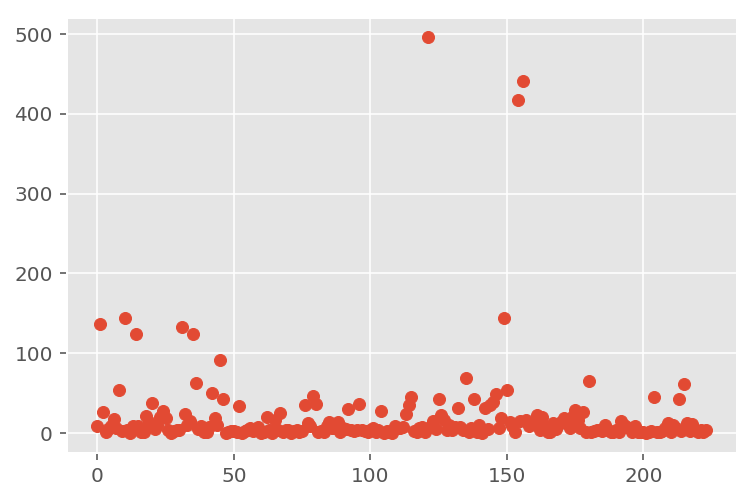

In [15]:
plt.scatter(id, RMSE/com_saleList)

## 残差プロット

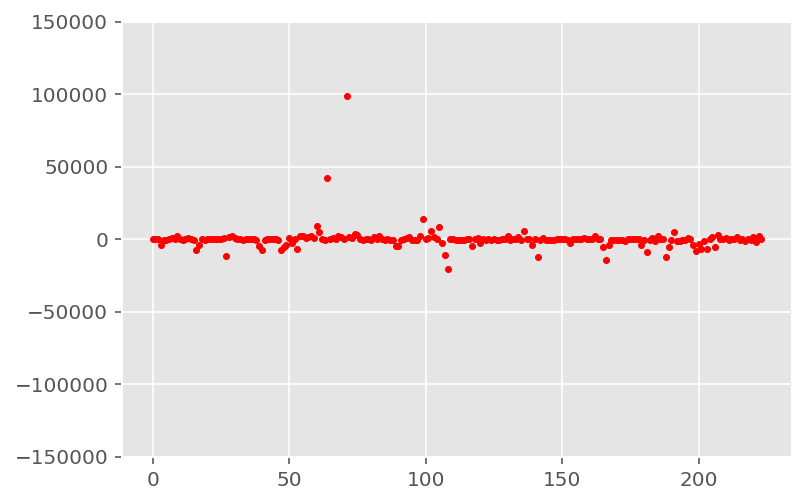

In [16]:
plt.ylim(-150000, 150000)
plt.scatter(id, e, c='red', marker='.')

## 理論値売上に対する誤差

In [17]:
sum(abs(e))/len(com_saleList)

2353.1528347375415

In [18]:
x = predictList*k

In [19]:
y = com_saleList

In [20]:
np.corrcoef(x,y)

array([[1.        , 0.94154644],
       [0.94154644, 1.        ]])

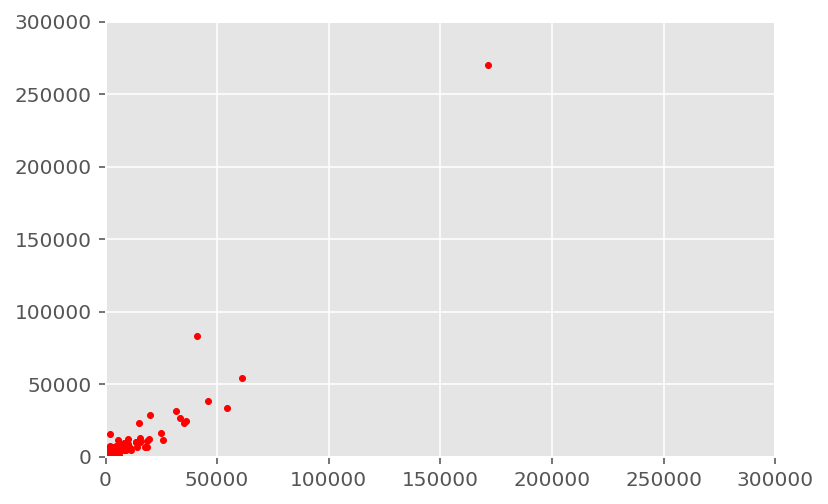

In [21]:
#理論値と予測値の散布図
plt.xlim(0, 300000)
plt.ylim(0, 300000)
plt.scatter(x, y, c='red', marker='.')

## 基本プロット

([array([213.,   6.,   3.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
           0.,   0.,   0.,   0.]),
  array([213.,   8.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   1.,   0.])],
 array([     0.,  20000.,  40000.,  60000.,  80000., 100000., 120000.,
        140000., 160000., 180000., 200000., 220000., 240000., 260000.,
        280000., 300000.]),
 <a list of 2 Lists of Patches objects>)

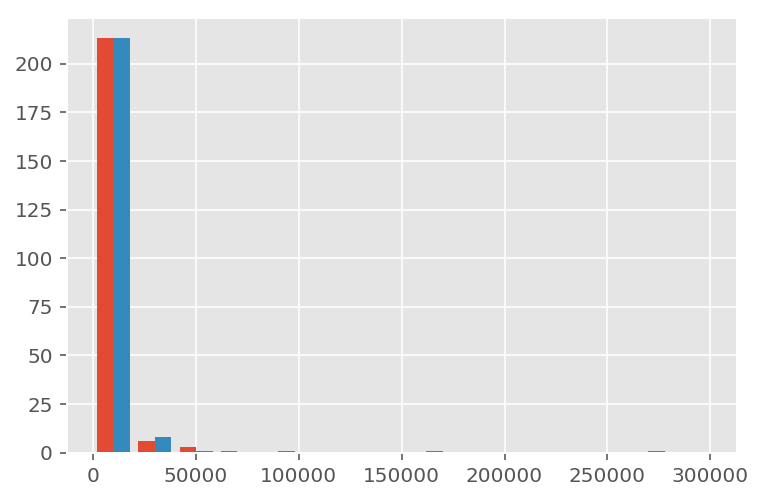

In [22]:
#predicted data(予測値)

plt.hist([x, y], stacked=False, range=(0, 300000), bins=15)

## 誤差のcsv出力

In [23]:
data1 = pd.DataFrame(id)
data2 = pd.DataFrame(com_name)
data3 = pd.DataFrame(e)
data = pd.concat([data1, data2, data3], axis=1)
#utf-8 でダメなら　shift-jis で
data.to_csv("data.csv", encoding = "utf-8")